# Введение в нейронные сети

## Урок 8. GAN

Обучите нейронную сеть любой архитектуры на каком-то производственном датасете.  
Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.  
Можно выполнить сегментацию по Северстали.  
В конце, обязательно подвести вывод.

---

Т.к. вычислетельные мощности ограничен, вернемся к менее ресурсоемким задачам.  
Попробуем сегментирвать изображение домашних животных из датасета Oxford-IIIT Pet Dataset, с использованием модифицированной версии U-Net.

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\shive\appdata\local\temp\pip-req-build-i8nkg2o1
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=303792 sha256=dbd9fd542200947c354387ec4ccd88c0eafe94a9ba8880d416c846ec81ae6303
  Stored in directory: C:\Users\shive\AppData\Local\Temp\pip-ephem-wheel-cache-0zyd4m2q\wheels\91\9b\e8\6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\shive\AppData\Local\Temp\pip-req-build-i8nkg2o1'


In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds

import keras
from keras import utils
from keras.losses import SparseCategoricalCrossentropy


from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

### Загрузка датасета

Oxford-IIIT Pet Dataset входит в набор датасетов TensorFlow, но необходимо установить модуль tensorflow-datasets.

In [2]:
#Download the Oxford-IIIT Pets dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*',shuffle_files=True , with_info=True)

In [3]:
# нормализация изобюражения
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1  # пиксели сегментационной маски помечаем как {0, 1, 2}
  return input_image, input_mask

Следующий код выполнит простую аугументацию данных посредством переворота изображений.

In [4]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  # data augmentation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
# transform for test data
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

Датасет уже содержит необходимые тестовый и тренеровочный сплиты, поэтому будем использовать их.

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32 #64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [9]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

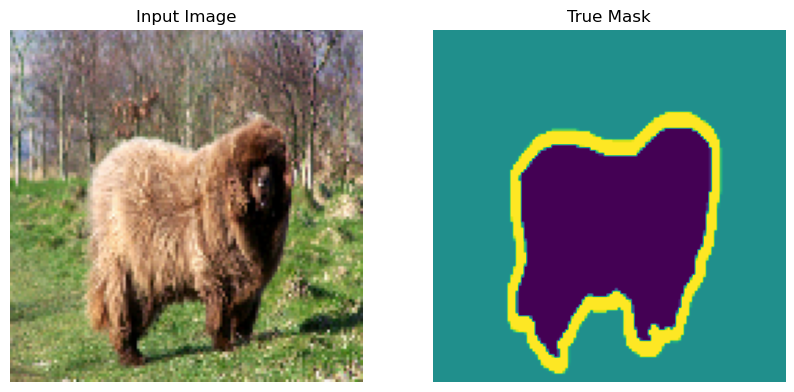

In [10]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### Создание модели

Будем использовать модифицированный U-Net.

Для ускорения процесса обучения в качестве энкодера будет использоваться предобученный MobileNetV2.  
Энкодер состоит из определенных аутпутов из средних слоев модели и не будет участвовать в процессе тренировки модели.

Для декодера, мы будем использовать повышающий дискретизацию блок, который уже реализован в Pix2pix.

In [11]:
OUTPUT_CHANNELS = 3

In [12]:
from keras.applications import MobileNetV2 # MobileNetV3Large, ResNet50,
from keras import Model # layers, losses

# base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet", pooling="max")
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False)

# Use the activations of these layers
layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [13]:
down_stack.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 1,841,984 (7.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,841,984 (7.03 MB)

In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [15]:
from keras.layers import Input, Concatenate, Conv2DTranspose
from keras import regularizers

def unet_model(output_channels):
  inputs = Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = Concatenate() # take an object
    x = concat([x, skip])

  # This is the last layer of the model
  last = Conv2DTranspose(
      OUTPUT_CHANNELS, 3, strides=2,
      padding='same',  #64x64 -> 128x128
      activation='silu',
      #kernel_initializer="he_uniform",
      kernel_regularizer=regularizers.L2(0.001),
  )

  x = last(x)

  return Model(inputs=inputs, outputs=x)

### Тренировка модели

Нейросеть пытается назначить каждому пикселю лейбл, также как в задачах предсказания класса. Для модели в которой 3 каннала каждый из которых пытается предсказать класс обычно рекомендуется использовать функцию потерь `SparseCategoricalCrossentropy(from_logits=True)`.

In [16]:
model = unet_model(OUTPUT_CHANNELS)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.91, beta_2=0.998),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  1,476,608 │ functional_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      4,323 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,504,227 (24.81 MB)

 Trainable params: 4,660,323 (17.78 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

Посмотрим на получившуюся архитектуру модели.

In [17]:
utils.plot_model(base_model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


На выходе нейросети каждому пикселю назначается лейбл с наибольшим значением.

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

Попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


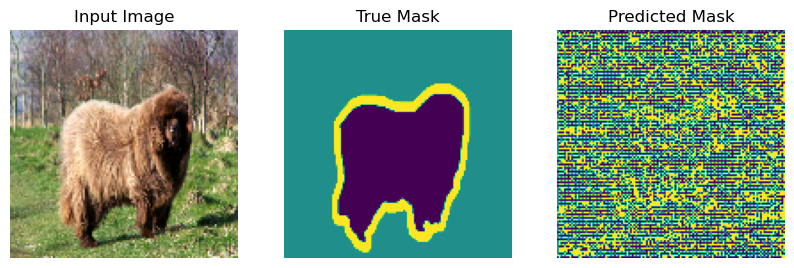

In [20]:
show_predictions()

Будем мониторировать улучшение работы модели в процессе обучения. Для этого определим callback-функцию.

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step/step - accuracy: 0.7128 - loss: 0.654


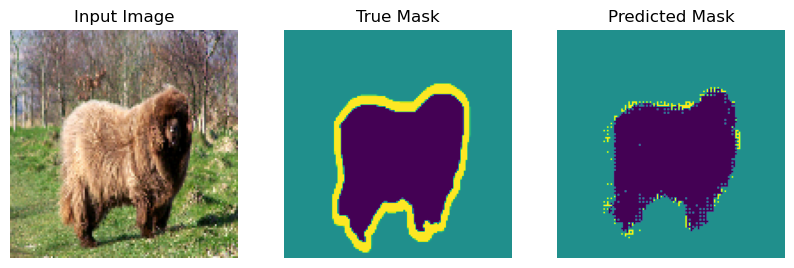


Sample Prediction after epoch 1

115/115 ━━━━━━━━━━━━━━━━━━━━ 73s 600ms/step - accuracy: 0.7136 - loss: 0.6531 - val_accuracy: 0.8316 - val_loss: 0.4176
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step/step - accuracy: 0.8684 - loss: 0.369


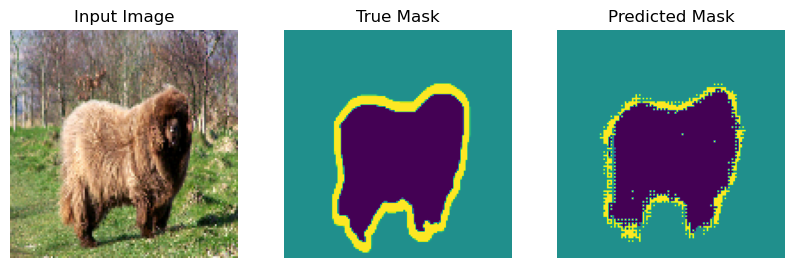


Sample Prediction after epoch 2

115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 620ms/step - accuracy: 0.8685 - loss: 0.3695 - val_accuracy: 0.8634 - val_loss: 0.3776
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step/step - accuracy: 0.8800 - loss: 0.350


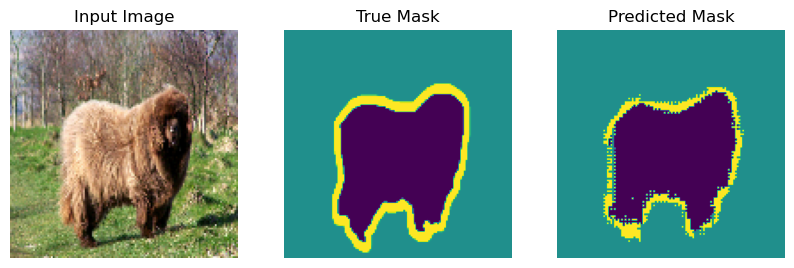


Sample Prediction after epoch 3

115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 612ms/step - accuracy: 0.8800 - loss: 0.3505 - val_accuracy: 0.8670 - val_loss: 0.3797
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step/step - accuracy: 0.8847 - loss: 0.340


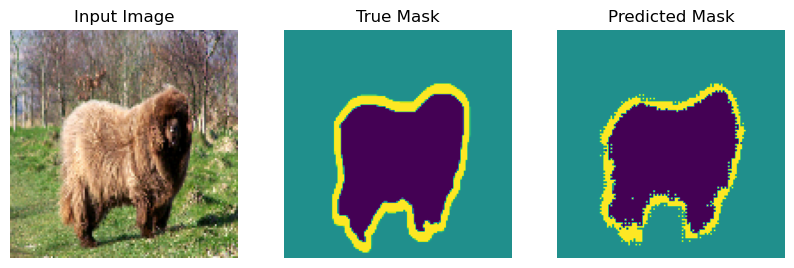


Sample Prediction after epoch 4

115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 616ms/step - accuracy: 0.8847 - loss: 0.3404 - val_accuracy: 0.8816 - val_loss: 0.3657
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step/step - accuracy: 0.8885 - loss: 0.331


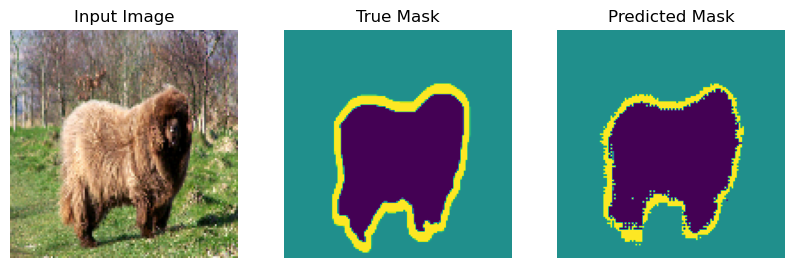


Sample Prediction after epoch 5

115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 609ms/step - accuracy: 0.8885 - loss: 0.3317 - val_accuracy: 0.8820 - val_loss: 0.3550
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step/step - accuracy: 0.8907 - loss: 0.326


c:\Users\shive\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


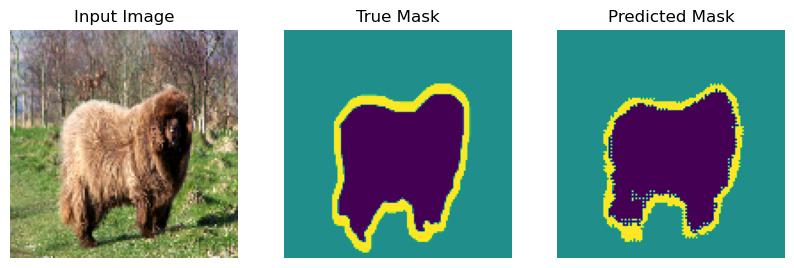


Sample Prediction after epoch 6

115/115 ━━━━━━━━━━━━━━━━━━━━ 62s 537ms/step - accuracy: 0.8907 - loss: 0.3261 - val_accuracy: 0.8820 - val_loss: 0.3544
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step/step - accuracy: 0.8929 - loss: 0.321


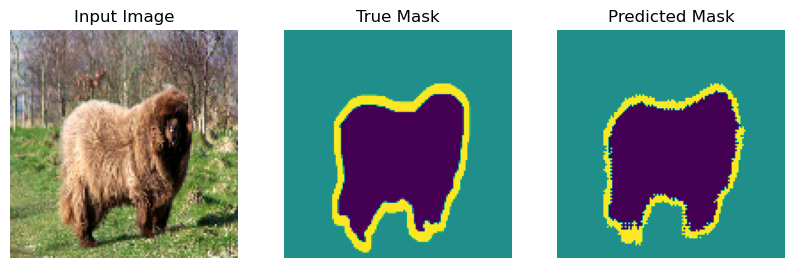


Sample Prediction after epoch 7

115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 615ms/step - accuracy: 0.8929 - loss: 0.3217 - val_accuracy: 0.8869 - val_loss: 0.3534
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step/step - accuracy: 0.8971 - loss: 0.311


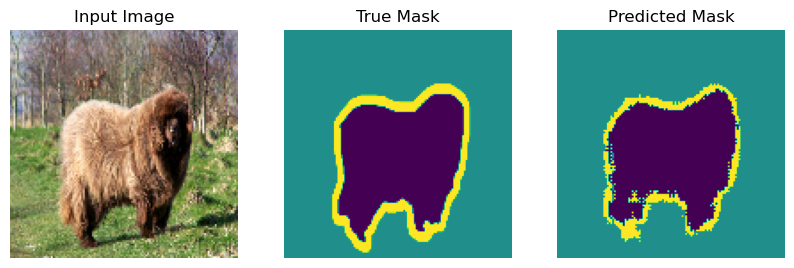


Sample Prediction after epoch 8

115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 612ms/step - accuracy: 0.8971 - loss: 0.3110 - val_accuracy: 0.8835 - val_loss: 0.3525
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step/step - accuracy: 0.8993 - loss: 0.304


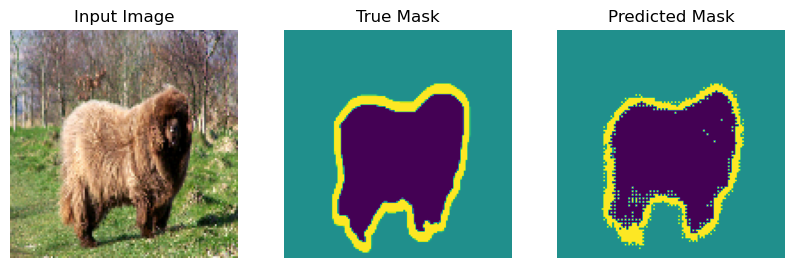


Sample Prediction after epoch 9

115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 611ms/step - accuracy: 0.8993 - loss: 0.3045 - val_accuracy: 0.8828 - val_loss: 0.3601
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step/step - accuracy: 0.9020 - loss: 0.298


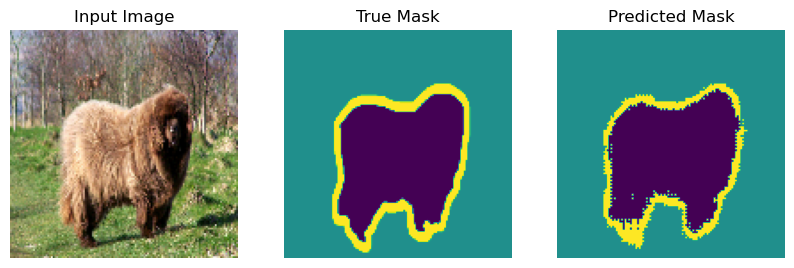


Sample Prediction after epoch 10

115/115 ━━━━━━━━━━━━━━━━━━━━ 70s 608ms/step - accuracy: 0.9020 - loss: 0.2985 - val_accuracy: 0.8859 - val_loss: 0.3702


In [22]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          verbose = 1,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

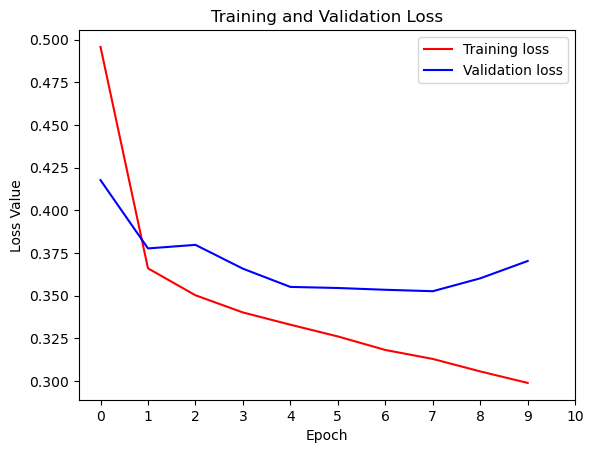

In [23]:
plt.plot(model_history.history['loss'], 'r', label='Training loss')
plt.plot(model_history.history['val_loss'], 'b', label='Validation loss')
plt.xticks(np.arange(0, EPOCHS+1, 1.0))
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend();

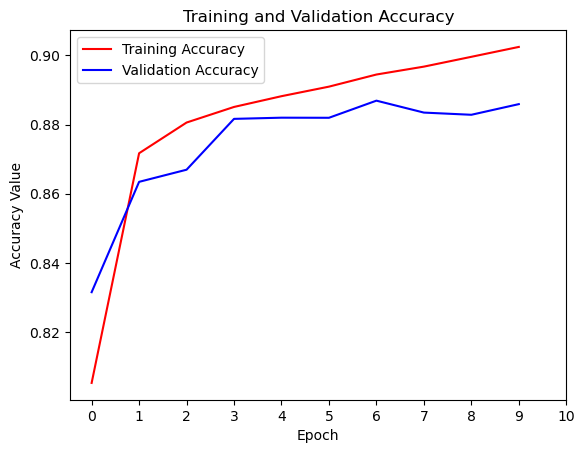

In [24]:
plt.plot(model_history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.xticks(np.arange(0, EPOCHS+1, 1.0))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend();

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


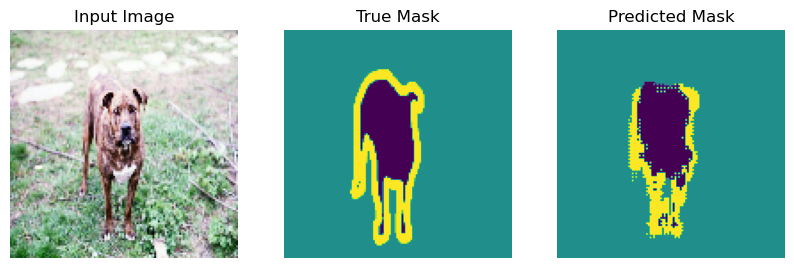

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


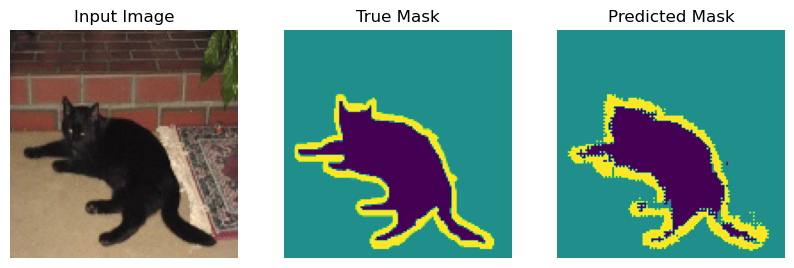

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


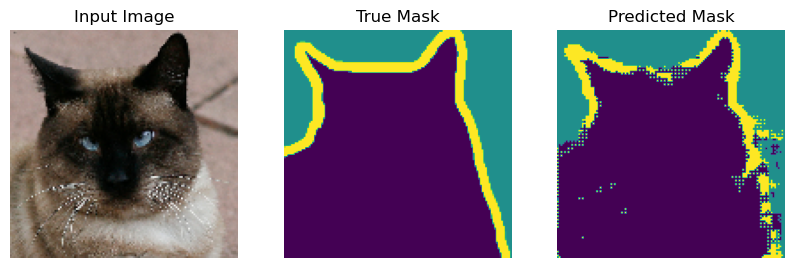

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


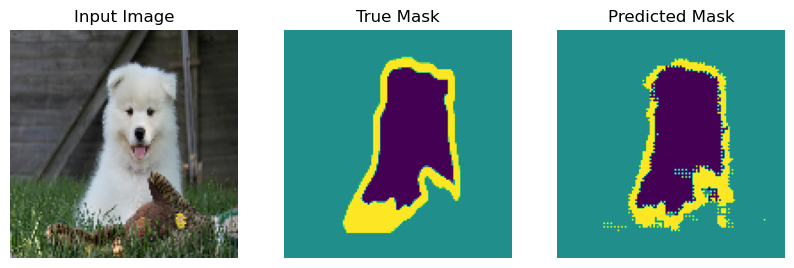

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


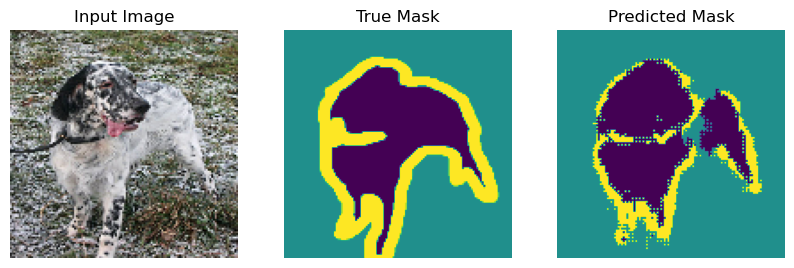

In [25]:
show_predictions(test_dataset, 5)

### Выводы

В результате работы была выполнена задача сегментации изображений домашних животных из набора данных Oxford-IIIT Pet Dataset. Данный набор данных включён в состав наборов данных TensorFlow и содержит готовые тестовые и тренировочные разделения. Для обогащения данных была применена простая методика их изменения путём поворота изображений.

В процессе работы применялась модифицированная версия архитектуры U-Net. Для ускорения обучения был использован предварительно обученный MobileNetV2 в качестве кодировщика. Декодер содержал блок повышения дискретизации из Pix2pix.

Выбор модели обучения основывался на использовании функции потерь SparseCategoricalCrossentropy(from_logits=True) и метрики точности.

После примерно десятого этапа обучения наблюдалось снижение точности и признаки переобучения модели. Наилучшие результаты были достигнуты на десятом этапе обучения со значением точности 0,8859.